In [1]:
import numpy as np

!pip install igraph

import igraph as ig
import matplotlib.pyplot as plt

Defaulting to user installation because normal site-packages is not writeable


In [115]:
N = 10
k_mean = 6
b = 1.5
x = 0.3

def get_Adj(alpha, N):
  # if alpha is smaller than 1 we get enyos, if it is an integer
  # bigger than 1 than it is used as m for barabasi
    if alpha < 1:
        g = ig.Graph.Erdos_Renyi(n=N, p= alpha)
        Adj = g.get_adjacency()
        return np.array(list(Adj))
    else:
        g =  ig.Graph.Barabasi(n=N, m=2, power  = alpha)
        Adj = g.get_adjacency()
        return np.array(list(Adj))

def init(N,x):
    # returns an (N,3) matrix with the before mentioned initial conditions.
    # first column is strategy, second one is UR, third is payoff.
    # using 0,1 to differentiate
    nodes = np.zeros((N,3))
    nodes[:,0] = np.random.choice([0,1],size= N, p = [0.5,0.5]) # assigning the strategies
    nodes[:,1] = np.random.choice([0,1],size= N, p = [(1-x),x]) # the UR
    return nodes

def REP(Adj, nodes, i, b = 2):
    neighbours_mask = (Adj[i] != 0)
    neighbours_indexes = np.nonzero(neighbours_mask)[0]
    # if node does not have any neigbours, it keeps its strat
    if len(neighbours_indexes) == 0:
        return nodes[i]
    # select random neighbour
    j = np.random.choice(neighbours_indexes)
    # selecting the utilities
    f_i, f_j = nodes[i][2], nodes[j][2]
    if f_j > f_i:
        Prob = (f_j - f_i)/(b*max(sum(Adj[i]), sum(Adj[j])))
        check =  np.random.rand()
        # with Prob copy strat, otherwise keep
        if check<Prob:
            return nodes[j]
        else:
            return nodes[i]
    return nodes[i]


def UI(Adj, nodes, i):
    # selecting the neighbours, if non, return strat
    neighbours_mask = (Adj[i] != 0)
    neighbours_indexes = np.nonzero(neighbours_mask)[0]
    if len(neighbours_indexes) == 0:
        return nodes[i]
    nodes_neighbours = nodes[neighbours_indexes]
    # sort nodes based on utility( third column)
    # richest is the last one
    sorted_indexes = np.argsort(nodes_neighbours[:,2])
    j = neighbours_indexes[sorted_indexes[-1]]
    # copy if it has more utility
    f_i, f_j = nodes[i][2], nodes[j][2]
    if f_j> f_i:
        return nodes[j]
    return nodes[i]


def MOR(Adj, nodes, i):
    # copy strat of neighbours with prob related to their utility
    if sum(Adj[i]*nodes[:,2]) ==0:
        return nodes[i]
    p = Adj[i]*nodes[:,2]/sum(Adj[i]*nodes[:,2])
    #print(p)
    j = np.random.choice(np.arange(len(nodes)), p = p)
    return nodes[j]





def convergence(update, iterations, alpha, N, b, x, Print = False):
    CL = 30 # check_length
    data = np.zeros((iterations,2))
    Adj = get_Adj(alpha,N)
    old_nodes = list(init(N,x))
    if Print:
        print('adj:')
        print(Adj)
    for i in range(iterations):
        new_nodes = update(Adj, np.array(old_nodes),N,b, Print)
        avg_values = np.sum(new_nodes[:, [0, 1]], axis=0) / N
        data[i] = avg_values
        if i > CL:
            # check for convergence, if std < 0.0005 for both, return 
            std = np.std(data[i-CL:i], axis = 0)
            if std[0] < 0.0005 and std[1] < 0.0005:
                return data[:i]
        old_nodes = list(new_nodes)
    return data

def update_REPvsMOR(Adj, nodes, N = N, b = b, Print = False):
    # this function is strategy dependent and might be adjusted when needed
    new_nodes = np.zeros((N,3))
    nodes = play(Adj, nodes, b)
    if Print:
        print('-----')
        print(nodes)
    for i in range(N):
        # again, change strat accordingly
        if nodes[i][1] == 0:
            new_nodes[i] = MOR(Adj, nodes,i)
        else:
            new_nodes[i] = REP(Adj, nodes,i)
    new_nodes[:,2] = 0
    return new_nodes

def update_UIvsMOR(Adj, nodes, N, b, Print):
    # this function is strategy dependent and might be adjusted when needed
    new_nodes = np.zeros((N,3))
    nodes = play(Adj, nodes, b)
    for i in range(N):
        # again, change strat accordingly
        if nodes[i][1] == 0:
            new_nodes[i] = MOR(Adj, nodes,i)
        else:
            new_nodes[i] = UI(Adj, nodes,i)
    new_nodes[:,2] = 0
    return new_nodes

def update_UIvsREP(Adj, nodes,N,b,Print):
    # this function is strategy dependent and might be adjusted when needed
    new_nodes = np.zeros((N,3))
    nodes = play(Adj, nodes, b)
    for i in range(N):
        # again, change strat accordingly
        if nodes[i][1] == 0:
            new_nodes[i] =  REP(Adj, nodes,i)
        else:
            new_nodes[i] = UI(Adj, nodes,i)
    new_nodes[:,2] = 0
    return new_nodes




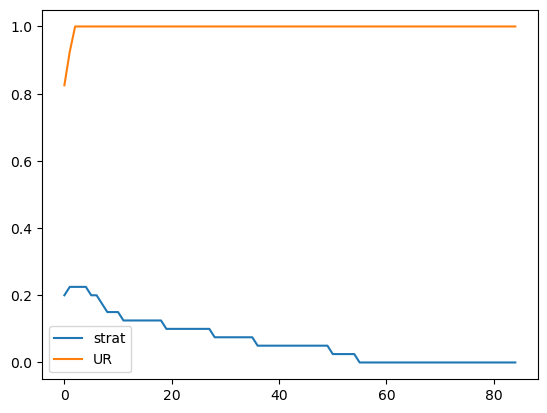

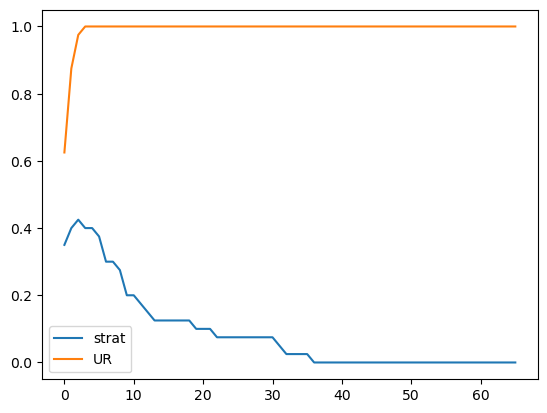

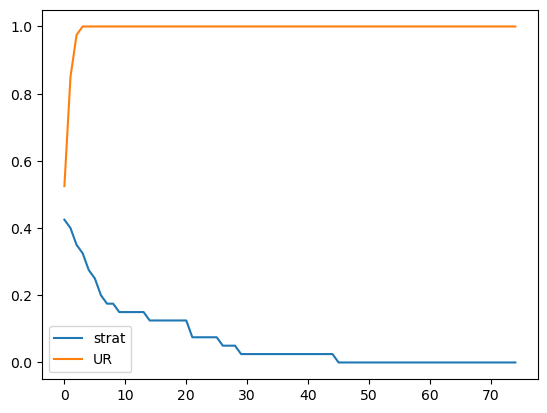

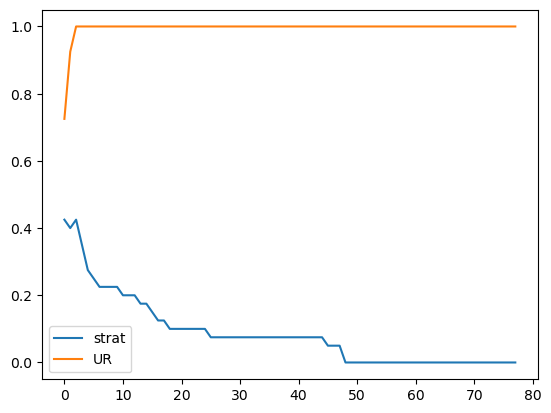

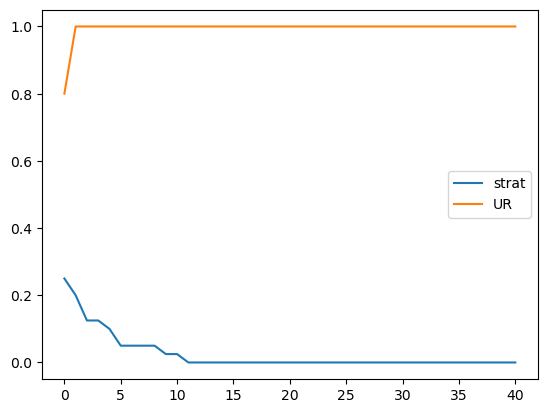

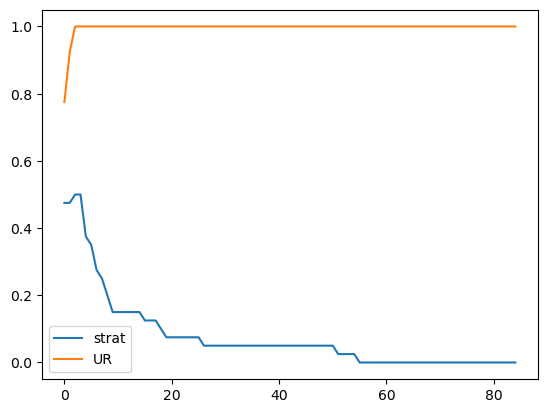

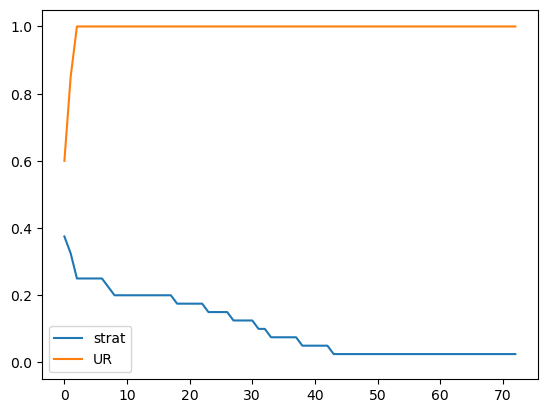

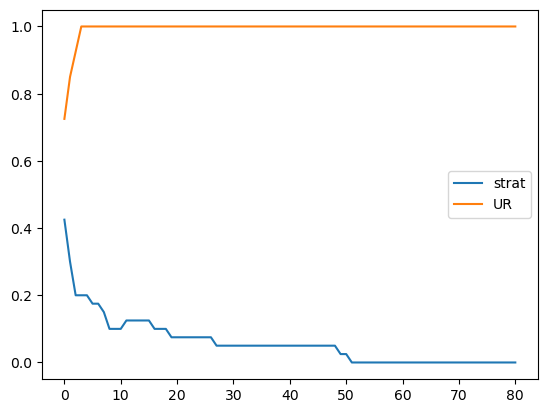

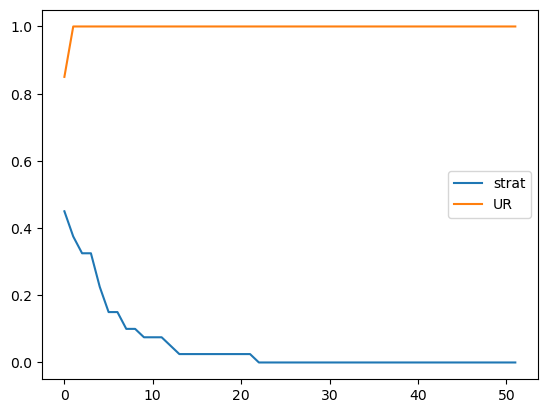

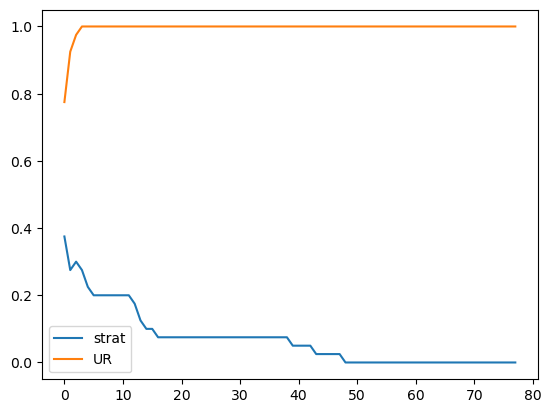

In [117]:
def play(Adj, nodes, b = b):
    # getting the degree vector
    degree = np.sum(Adj, axis = 0)
    u = np.ones(len(degree))
    strat = nodes[:,0] # strategie vector of nodes
    strat_neigh = Adj@strat #sum strat of neighbours => adj is symmetric
    #  utilities then become
    nodes[:,2] = ((u-strat)*(strat_neigh)*b + strat*(strat_neigh))
    return nodes

for _ in range(10):
    data = convergence(update_REPvsMOR,100, 0.6, 40, b  = 2,x = 0.5, Print = False)
    plt.plot(data[:,0], label = 'strat')
    plt.plot(data[:,1], label = 'UR')
    plt.ylim((-0.05,1.05))
    plt.legend()
    plt.show()

0
1
2
3
4
5
6
7
8
9


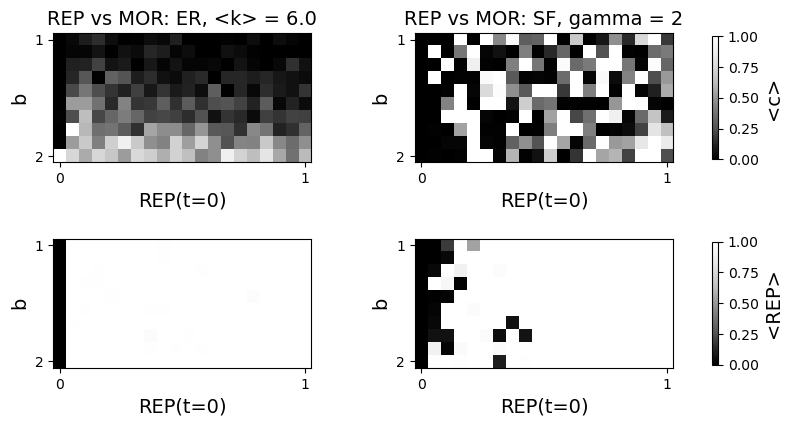

0
1
2
3
4
5
6
7
8
9


KeyboardInterrupt: 

In [124]:

def plot(update, title, xlabel,alpha1, alpha2, iterations = 100,N =100, rowsX = 20, intervalB = 0.1,mean = 1):
    B = np.arange(1,2,intervalB)
    X = np.linspace(0,1,rowsX)
    output_str = np.zeros((len(B), len(X)))
    output_UR = np.zeros((len(B), len(X)))
    output_str2 = np.zeros((len(B), len(X)))
    output_UR2= np.zeros((len(B), len(X)))
    for i,b in enumerate(B):
        print(i)
        for j,x in enumerate(X):
            for _ in range(mean):
                data = convergence(update, iterations, alpha1, N, b, x)
                output_str[i,j] += data[-1][0]
                output_UR[i,j] += data[-1][1]
                data = convergence(update, iterations, alpha2, N, b, x)
                output_str2[i,j] += data[-1][0]
                output_UR2[i,j] += data[-1][1]
                
    output_str = output_str/mean
    output_UR = output_UR/mean
    output_str2 = output_str2/mean
    output_UR2 = output_UR2/mean
    
    fig, axs = plt.subplots(nrows = 2,ncols = 2, figsize = (10,8))
    fig.subplots_adjust(hspace = -0.5, wspace = 0.4 )
    im = axs[0,0].imshow(output_str, cmap = 'Greys_r',origin='lower')
    im.set_clim(0, 1)
    axs[0,0].set_title(title + ": ER, <k> = " + str(np.round(alpha1*(N-1),2)), fontsize=14)
    axs[0,0].set_yticks([0,len(B)-1], [2,1])
    axs[0,0].set_xticks([0,len(X)-1], [0,1])
    axs[0,0].set_ylabel("b", fontsize=14)
    axs[0,0].set_xlabel(xlabel+"(t=0)", fontsize=14)
    im = axs[0,1].imshow(output_str2, cmap = 'Greys_r',origin='lower')
    im.set_clim(0, 1)
    cbar = plt.colorbar(im, ax = axs[0,[0,1]] ,shrink = 0.3)
    cbar.set_label(size=14,label = "<c>")
    axs[0,1].set_title(title + ": SF, gamma = " + str(alpha2), fontsize=14)
    axs[0,1].set_yticks([0,len(B)-1], [2,1])
    axs[0,1].set_xticks([0,len(X)-1], [0,1])
    axs[0,1].set_ylabel("b", fontsize=14)
    axs[0,1].set_xlabel(xlabel+"(t=0)", fontsize=14)
    im = axs[1,0].imshow(output_UR, cmap = 'Greys_r',origin='lower')
    im.set_clim(0, 1)
    axs[1,0].set_yticks([0,len(B)-1], [2,1])
    axs[1,0].set_xticks([0,len(X)-1], [0,1])
    axs[1,0].set_ylabel("b", fontsize=14)
    axs[1,0].set_xlabel(xlabel+"(t=0)", fontsize=14)
    im = axs[1,1].imshow(output_UR2, cmap = 'Greys_r',origin='lower')
    cbar = plt.colorbar(im, ax = axs[1,[0,1]] ,shrink = 0.3)
    cbar.set_label(size=14, label = "<" + xlabel + ">")
    im.set_clim(-0, 1)
    axs[1,1].set_yticks([0,len(B)-1], [2,1])
    axs[1,1].set_xticks([0,len(X)-1], [0,1])
    axs[1,1].set_ylabel("b", fontsize=14)
    axs[1,1].set_xlabel(xlabel+"(t=0)", fontsize=14)
    plt.show()




plot(update_REPvsMOR, 'REP vs MOR', "REP", alpha1 = 0.06060606060606061, alpha2 = 2)
plot(update_UIvsREP, 'REP vs UI', "REP",alpha1 = 0.06060606060606061, alpha2 = 2)
plot(update_UIvsMOR, 'UI vs MOR', "UI",alpha1 = 0.06060606060606061, alpha2 = 2)




In [94]:
6/(99)

0.06060606060606061

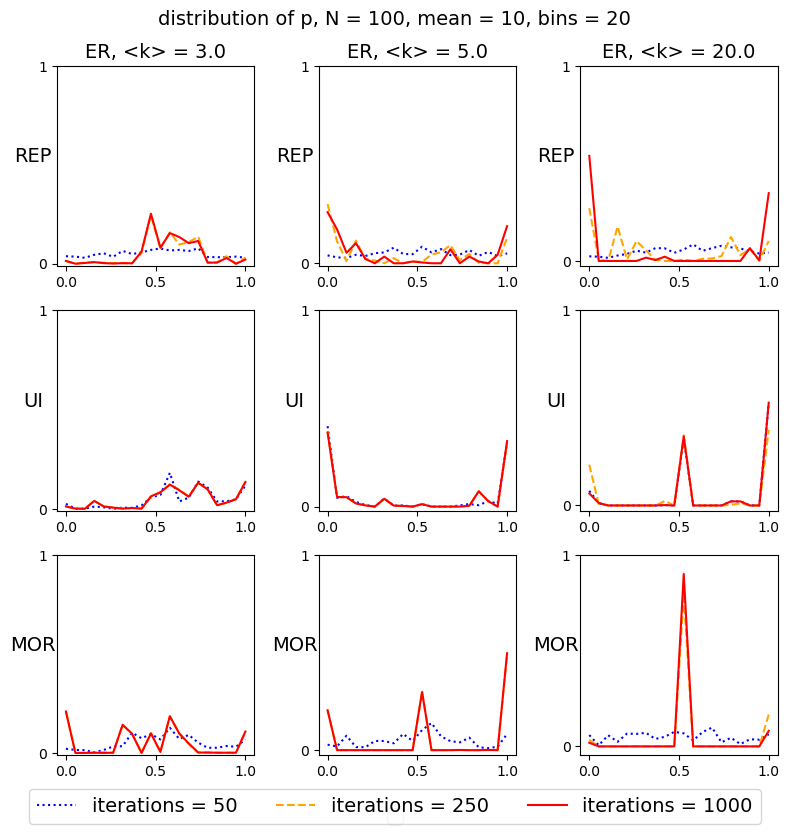

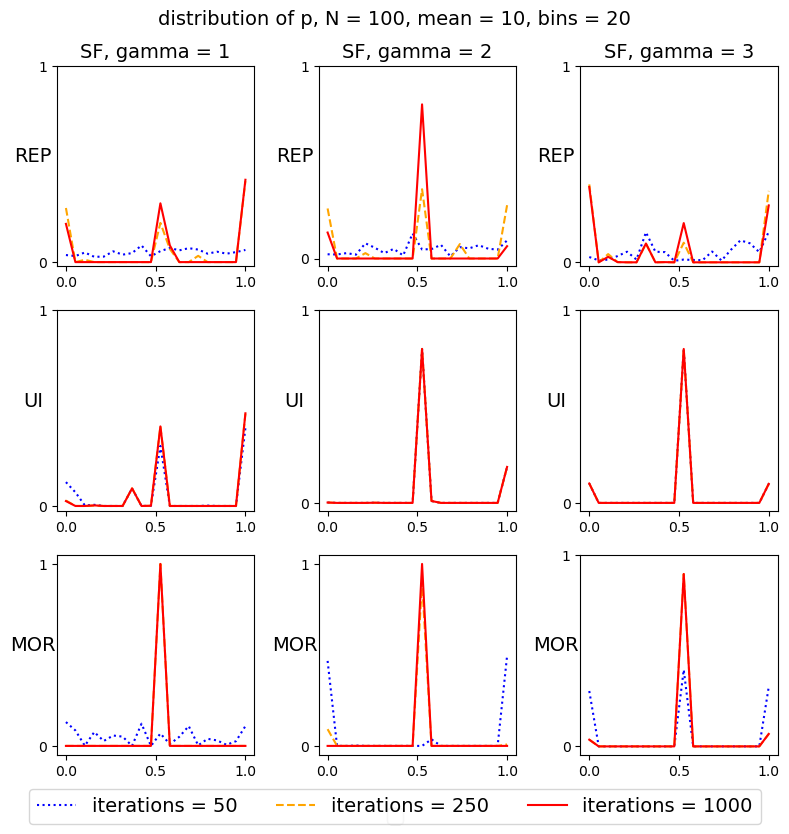

In [132]:
# we can reuse most of the code
def init_pminusq(N):
    nodes = np.zeros((N, 3))
    nodes[:, 0] = np.random.rand(N) # p
    nodes[:, 1] = 1 - nodes[:, 0] # q = 1 - p
    return nodes

def play_ultimatum(Adj, nodes, b=b):
    N = len(Adj)
    for i in range(N):
        neighbours_mask = (Adj[i] != 0)
        neighbours_indexes = np.nonzero(neighbours_mask)[0]
        for j in neighbours_indexes:
            if Adj[i][j] == 1:
                pi, qi = nodes[i][0], nodes[i][1]
                pj, qj = nodes[j][0], nodes[j][1]
                if pi > qj:
                    nodes[i][2] += 1 - pi
                    nodes[j][2] += pi
                if pj > qi:
                    nodes[j][2] += 1 - pj
                    nodes[i][2] += pj
    nodes[:, 2] = nodes[:, 2] / 2
    return np.array(nodes)


def play_ultimatum(Adj, nodes, b=b):
    N = len(Adj)
    for i in range(N):
        neighbours_mask = (Adj[i] != 0)
        neighbours_indexes = np.nonzero(neighbours_mask)[0]
        for j in neighbours_indexes:
            if Adj[i][j] == 1:
                pi, qi = nodes[i][0], nodes[i][1]
                pj, qj = nodes[j][0], nodes[j][1]
                if pi + pj > 1:
                    nodes[i][2] += (1 - pi) + pj
                    nodes[j][2] += (1-pj) + pi

    nodes[:, 2] = nodes[:, 2] / 2
    return np.array(nodes)


def update_ultimatum(selection, Adj, nodes, N=N, b=b):
    new_nodes = np.zeros((N, 3))
    nodes = play_ultimatum(Adj, nodes, b)
    for i in range(N):
        new_nodes[i][:2] = selection(Adj, nodes, i)[:2]
    return new_nodes

def convergence_ultimatum(selection, iterations, alpha, N, bins):
    data = []
    Adj = get_Adj(alpha, N)
    old_nodes = init_pminusq(N)
    for i in range(iterations):
        new_nodes = update_ultimatum(selection, Adj, np.array(old_nodes), N)
        data.append(np.histogram(np.array(new_nodes[:,0]), bins = bins)[0])
        old_nodes = list(new_nodes)
    return data



def compare_final_strat(iterations = 1000 , N = 100, mean = 10, bins = 20, P =  [0.03,0.05,0.202]):
    fig, axs = plt.subplots(nrows= 3, ncols = 3, figsize =(8,8))
    Rule = [REP, UI, MOR]
    Rule_name = ['REP', 'UI', 'MOR']
    for p in range(3):
        for i in range(len(Rule)):      # summing over all rules
            rule = Rule[i]
            rule_name = Rule_name[i]
            alpha = P[p]
            data = np.zeros((iterations, bins))
            for j in range(mean):       # repeating for multiple ensembles
                data_mean= convergence_ultimatum(rule, iterations, alpha, N, bins)
                data += data_mean
            data /= mean
            axs[i,p].plot(np.linspace(0,1,bins),data[int(iterations/200)], alpha =1, ls = ":", label = f'iterations = {int(iterations/20)}', color = 'blue' )
            axs[i,p].plot(np.linspace(0,1,bins),data[int(iterations/4)], alpha =1, ls = '--',label = f'iterations = {int(iterations/4)}', color  = 'orange')
            axs[i,p].plot(np.linspace(0,1,bins),data[iterations-1], alpha =1, ls = '-',label = f'iterations = {int(iterations)}', color = 'red')
            axs[i,p].set_ylabel(rule_name, rotation=0, fontsize = 14)
            axs[i,0].set_yticks([0,N], [0,1])
            axs[i,1].set_yticks([0,N], [0,1])
            axs[i,2].set_yticks([0,N], [0,1])

        if alpha <1:
            axs[0,0].set_title(f'ER, <k> = {np.round(P[0]*(N-1),1)}', fontsize = 14)
            axs[0,1].set_title(f'ER, <k> = {np.round(P[1]*(N-1),1)}', fontsize = 14)
            axs[0,2].set_title(f'ER, <k> = {np.round(P[2]*(N-1),1)}', fontsize = 14)
        else:
            axs[0,0].set_title(f'SF, gamma = {np.round(P[0],1)}', fontsize = 14)
            axs[0,1].set_title(f'SF, gamma = {np.round(P[1],1)}', fontsize = 14)
            axs[0,2].set_title(f'SF, gamma = {np.round(P[2],1)}', fontsize = 14)
        fig.suptitle(f'distribution of p, N = {N}, mean = {mean}, bins = {bins}', fontsize = 14)
        handles, labels = plt.gca().get_legend_handles_labels()
        fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol = 3, fontsize = 14)
        fig.tight_layout()

compare_final_strat()
compare_final_strat(P = [1,2,3])





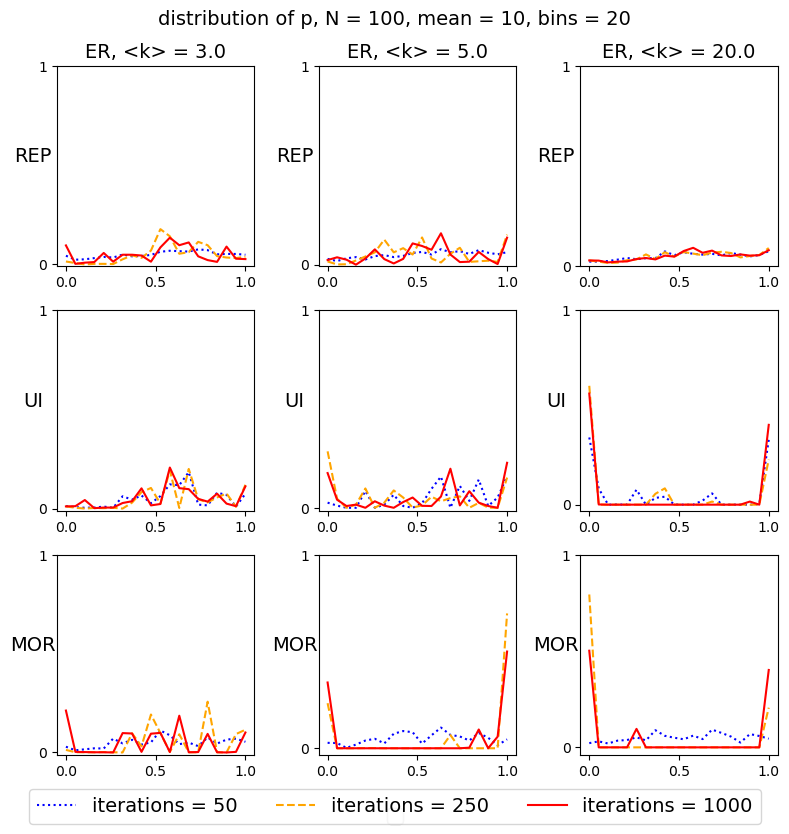

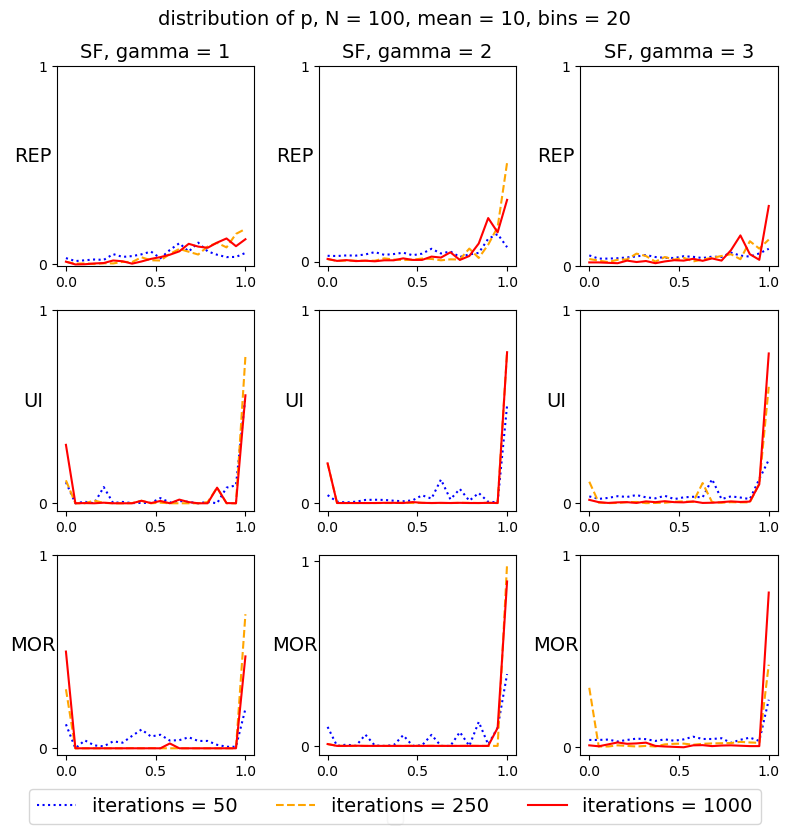

In [133]:
def update_social(selection, Adj, nodes, N=N, b=b):
    new_nodes = np.zeros((N, 3))
    nodes = play_ultimatum(Adj, nodes, b)
    # applying the penalty
    poor_node = np.argsort(nodes[:, 2])[0]
    friends_poor = (Adj[poor_node] != 0)
    friends_poor_indexes = np.nonzero(friends_poor)[0]


    number_reset = len(friends_poor_indexes)+1
    nodes_poor = np.zeros((number_reset,3))
    nodes_poor[:, 0] = np.random.rand(number_reset) # p
    nodes_poor[:, 1] = 1 - nodes_poor[:, 0]
    nodes[list(friends_poor_indexes) + [poor_node]] = nodes_poor

    for i in range(N):
        new_nodes[i][:2] = selection(Adj, nodes, i)[:2]
    return new_nodes



def convergence_social(selection, iterations, alpha, N, bins):
    data = []
    Adj = get_Adj(alpha, N)
    old_nodes = init_pminusq(N)
    for i in range(iterations):
        new_nodes = update_social(selection, Adj, np.array(old_nodes), N)
        data.append(np.histogram(np.array(new_nodes[:,0]), bins = bins)[0])
        old_nodes = list(new_nodes)
    return data



def compare_final_strat_social(iterations = 1000 , N = 100, mean = 10, bins = 20, P =  [0.03,0.05,0.202]):
    fig, axs = plt.subplots(nrows= 3, ncols = 3, figsize =(8,8))
    Rule = [REP, UI, MOR]
    Rule_name = ['REP', 'UI', 'MOR']
    for p in range(3):
        for i in range(len(Rule)):      # summing over all rules
            rule = Rule[i]
            rule_name = Rule_name[i]
            alpha = P[p]
            data = np.zeros((iterations, bins))
            for j in range(mean):       # repeating for multiple ensembles
                data_mean= convergence_social(rule, iterations, alpha, N, bins)
                data += data_mean
            data /= mean
            axs[i,p].plot(np.linspace(0,1,bins),data[int(iterations/200)], alpha =1, ls = ":", label = f'iterations = {int(iterations/20)}', color = 'blue' )
            axs[i,p].plot(np.linspace(0,1,bins),data[int(iterations/4)], alpha =1, ls = '--',label = f'iterations = {int(iterations/4)}', color  = 'orange')
            axs[i,p].plot(np.linspace(0,1,bins),data[iterations-1], alpha =1, ls = '-',label = f'iterations = {int(iterations)}', color = 'red')
            axs[i,p].set_ylabel(rule_name, rotation=0, fontsize = 14)
            axs[i,0].set_yticks([0,N], [0,1])
            axs[i,1].set_yticks([0,N], [0,1])
            axs[i,2].set_yticks([0,N], [0,1])

        if alpha <1:
            axs[0,0].set_title(f'ER, <k> = {np.round(P[0]*(N-1),1)}', fontsize = 14)
            axs[0,1].set_title(f'ER, <k> = {np.round(P[1]*(N-1),1)}', fontsize = 14)
            axs[0,2].set_title(f'ER, <k> = {np.round(P[2]*(N-1),1)}', fontsize = 14)
        else:
            axs[0,0].set_title(f'SF, gamma = {np.round(P[0],1)}', fontsize = 14)
            axs[0,1].set_title(f'SF, gamma = {np.round(P[1],1)}', fontsize = 14)
            axs[0,2].set_title(f'SF, gamma = {np.round(P[2],1)}', fontsize = 14)
        fig.suptitle(f'distribution of p, N = {N}, mean = {mean}, bins = {bins}', fontsize = 14)
        handles, labels = plt.gca().get_legend_handles_labels()
        fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol = 3, fontsize = 14)
        fig.tight_layout()

compare_final_strat_social()
compare_final_strat_social(P = [1,2,3])



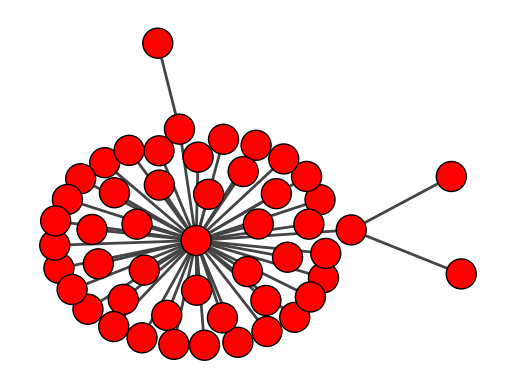

In [130]:
g = ig.Graph.Barabasi(n = 50, m = 1, power = 3)
fig, ax = plt.subplots()
ig.plot(g, target = ax)



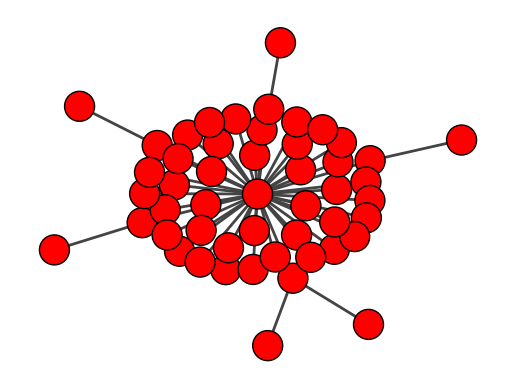

In [58]:
g = ig.Graph.Barabasi(n = 50, m = 1, power = 2)
fig, ax = plt.subplots()
ig.plot(g, target = ax)



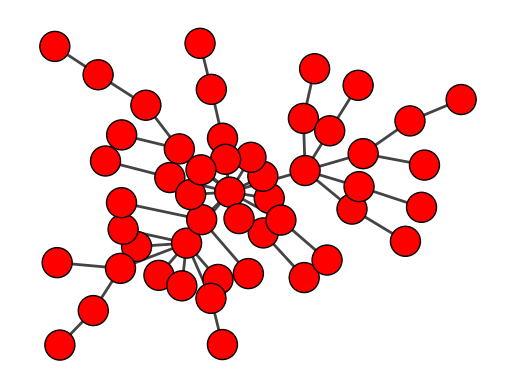

In [59]:
g = ig.Graph.Barabasi(n = 50, m = 1, power = 1)
fig, ax = plt.subplots()
ig.plot(g, target = ax)

